In [121]:
import os
import sys
import inspect

import subprocess
from glob import glob
from google.cloud import storage
import warnings

import numpy as np
from numpy import ma
import xarray as xr
from datetime import datetime, timedelta
from pyproj import Proj
import cv2 as cv
from scipy import interpolate
from scipy import ndimage as ndi

import matplotlib.pyplot as plt
from matplotlib import animation

# code from https://stackoverflow.com/questions/279237/import-a-module-from-a-relative-path?lq=1#comment15918105_6098238 to load a realitive folde from a notebook
# realpath() will make your script run, even if you symlink it :)
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

from utils import io, abi, flow

In [29]:
# Get GOES-16 ABI data
goes_data_path = './data/GOES16'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/jonesw/Downloads/dcc-detect-4e11a4adbc07.json'
date = datetime(2020,11,3,18)
goes16_files = io.find_abi_files(date, satellite=16, product='MCMIP', view='F', mode=6, 
                              save_dir=goes_data_path, 
                              replicate_path=True, check_download=True, 
                              n_attempts=1, download_missing=True)

print(len(goes16_files))

goes_data_path = './data/GOES17'
goes17_files = io.find_abi_files(date, satellite=17, product='MCMIP', view='F', mode=6, 
                              save_dir=goes_data_path, 
                              replicate_path=True, check_download=True, 
                              n_attempts=1, download_missing=True)

print(len(goes17_files))


1
1


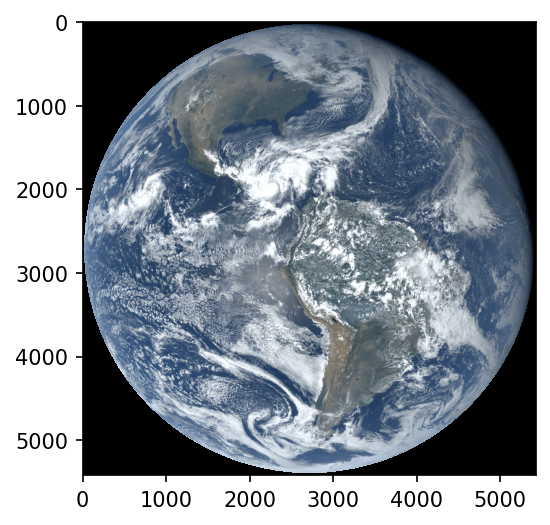

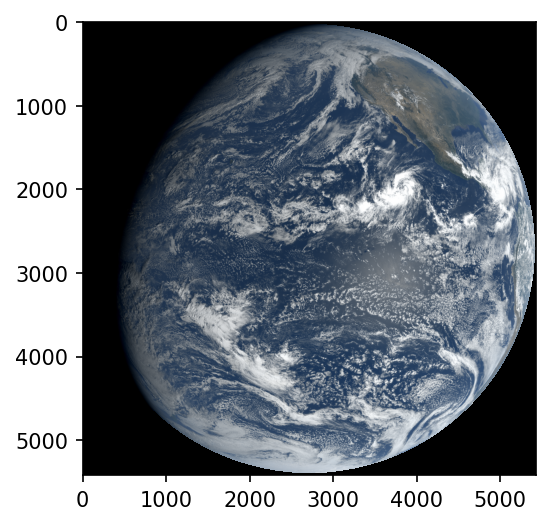

In [30]:
goes16ds = xr.open_dataset(goes16_files[0])
plt.figure(dpi=150)
plt.imshow(abi.get_abi_rgb(goes16ds))

goes17ds = xr.open_dataset(goes17_files[0])
plt.figure(dpi=150)
plt.imshow(abi.get_abi_rgb(goes17ds))


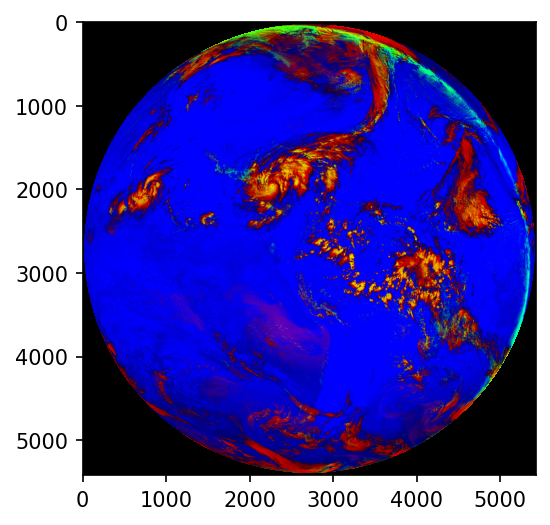

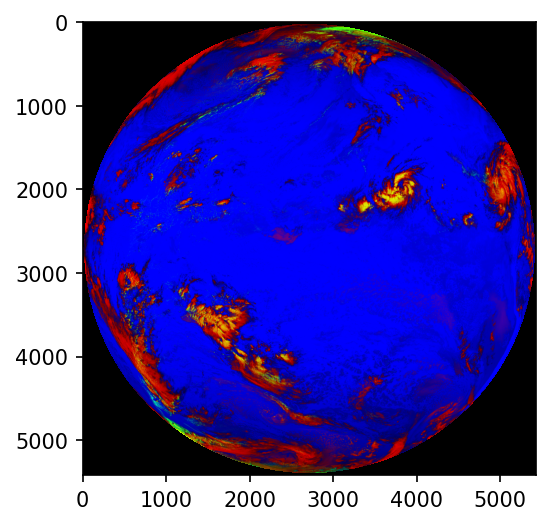

In [31]:
plt.figure(dpi=150)
plt.imshow(abi.get_abi_deep_cloud_rgb(goes16ds))

plt.figure(dpi=150)
plt.imshow(abi.get_abi_deep_cloud_rgb(goes17ds))


In [36]:
proj = Proj('+proj=eqdc +lon_0=-97.5 +lat_1=5 +lat_2=25 +lat_0=15 +datum=WGS84 +units=m +no_defs')

In [110]:
from utils.abi import get_abi_proj, get_abi_lat_lon
class remapper:
    def __init__(self, abi_ds, new_projection, shape=None, lon_bounds=None, lat_bounds=None):
        """
        Reproject a GOES-ABI image to a new perspective:

        Inputs:
        abi_ds -- and xarray dataset object of the abi data file
        new_projection -- a Proj4 projection of the new projection to map to

        Outputs:
        img -- a warped ABI image in the new projection
        """
        if shape is None:
            self.shape = abi_ds.y.shape + abi_ds.x.shape
            self.ds_shape = self.shape
        else:
            self.shape = shape
            self.ds_shape = abi_ds.y.shape + abi_ds.x.shape
        
#       Get limits of the original abi domain in the geostationary projection
        h = abi_ds.goes_imager_projection.perspective_point_height
        min_x = abi_ds.x.min().item() * h 
        max_x = abi_ds.x.max().item() * h 
        min_y = abi_ds.y.min().item() * h 
        max_y = abi_ds.y.max().item() * h 
        
        if lat_bounds and lon_bounds:
            new_x, new_y = new_projection(np.array([lon_bounds[0], lon_bounds[0], lon_bounds[1], lon_bounds[1]]), 
                                          np.array([lat_bounds[0], lat_bounds[1], lat_bounds[1], lat_bounds[0]]))
            x0 = new_x[np.isfinite(new_x)].min()
            x1 = new_x[np.isfinite(new_x)].max()
            y0 = new_y[np.isfinite(new_y)].min()
            y1 = new_y[np.isfinite(new_y)].max()
        elif not lat_bounds and not lon_bounds:
            print('Default bounds')
    #       Get lat and lon grids for the abi images
            geo_lats, geo_lons = get_abi_lat_lon(abi_ds)

    #       Project these lats and lons into the new projection
            new_x, new_y = new_projection(geo_lons, geo_lats)
            
            x0 = new_x[np.isfinite(new_x)].min()
            x1 = new_x[np.isfinite(new_x)].max()
            y0 = new_y[np.isfinite(new_y)].min()
            y1 = new_y[np.isfinite(new_y)].max()
            
        else:
            raise ValueError("Must supply both of lat and lon bounds if either is provided")

#       Create a regular range of x, y coords spanning the new projection
        x_range = np.linspace(x0, x1, self.shape[1])
        y_range = np.linspace(y0, y1, self.shape[0])

#       Convert the new coords back into the geostationary proejction
        geo_p = get_abi_proj(abi_ds)
        new_geo_x, new_geo_y = geo_p(*new_projection(*np.meshgrid(x_range, y_range), inverse=True))

#       Use the limits of the geostationary domain to limit the range to the original pixel indices
        new_geo_x = (new_geo_x - min_x)/(max_x-min_x)*(self.ds_shape[1]-1)
        new_geo_y = (new_geo_y - min_y)/(max_y-min_y)*(self.ds_shape[0]-1)

#       Mask missing values
        self.new_geo_x = ma.array(new_geo_x, mask=np.isinf(new_geo_x), dtype=np.float32)
        self.new_geo_y = ma.array(new_geo_y, mask=np.isinf(new_geo_y), dtype=np.float32)
    
    def __call__(self, img, engine='opencv', method='linear'):
        if engine == 'opencv':
            if len(img.shape) > 2:
                out_img = np.full(self.shape+img.shape[2:], np.nan, img.dtype)
            else:
                out_img = np.full(self.shape, np.nan, img.dtype)
            if method == 'linear':
                method = cv.INTER_LINEAR
            elif method =='nearest':
                method = cv.INTER_NEAREST
            else:
                raise ValueError("method must be either 'linear' or 'nearest'")
            cv.remap(img[::-1], 
                     self.new_geo_x.filled(-1).astype(np.float32), 
                     self.new_geo_y.filled(-1).astype(np.float32), 
                     method, out_img, cv.BORDER_TRANSPARENT)
            return out_img[::-1]
        elif engine == 'scipy':
            return interpolate.interpn((np.arange(self.ds_shape[0]), np.arange(self.ds_shape[1])), 
                                       img[::-1], 
                                       (self.new_geo_y.filled(-1), self.new_geo_x.filled(-1)), 
                                       method=method, 
                                       bounds_error=False, fill_value=np.nan)[::-1]
        else:
            raise ValueError("method must be 'opencv' or 'scipy'")

        

In [42]:
proj = Proj('+proj=eqdc +lon_0=-90 +lat_1=5 +lat_2=25 +lat_0=15 +datum=WGS84 +units=m +no_defs')

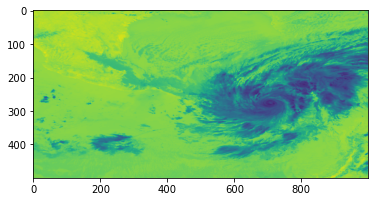

In [112]:
goes16_remapper = remapper(goes16ds, proj, shape=(500,1000), lat_bounds=[0,30], lon_bounds=[-75,-105])
plt.imshow(goes16_remapper(goes16ds.CMI_C13.data), vmin=180, vmax=320)

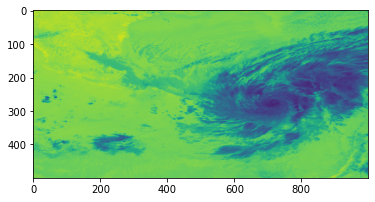

In [113]:
goes17_remapper = remapper(goes17ds, proj, shape=(500,1000), lat_bounds=[0,30], lon_bounds=[-75,-105])
plt.imshow(goes17_remapper(goes17ds.CMI_C13.data), vmin=180, vmax=320)

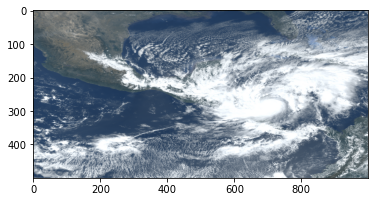

In [114]:
plt.imshow(goes16_remapper(abi.get_abi_rgb(goes16ds)))

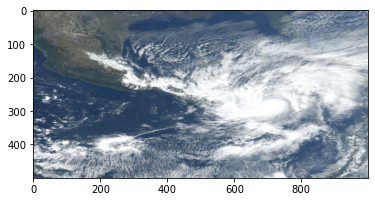

In [115]:
plt.imshow(goes17_remapper(abi.get_abi_rgb(goes17ds)))

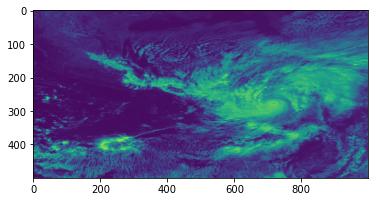

In [78]:
plt.imshow(goes17_remapper(goes17ds.CMI_C02.data), vmin=0, vmax=1)

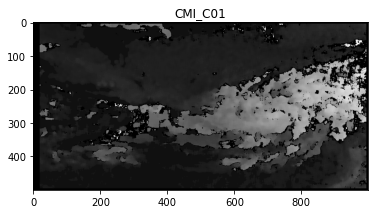

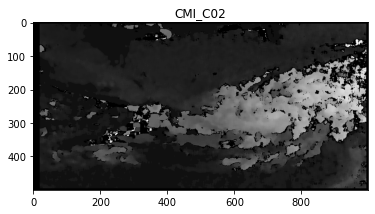

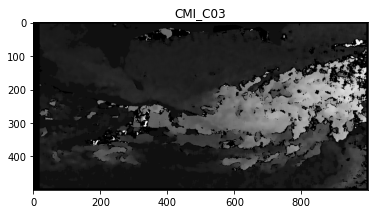

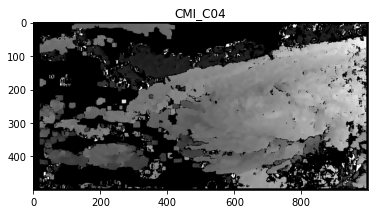

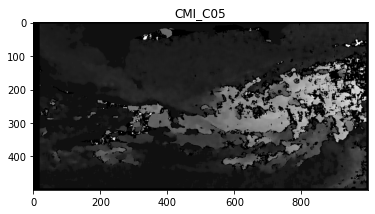

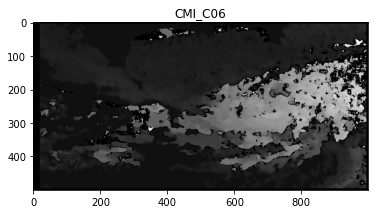

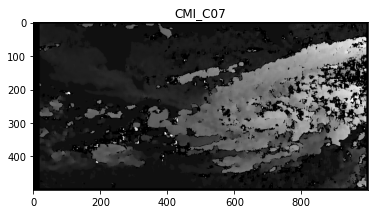

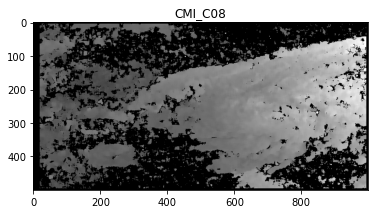

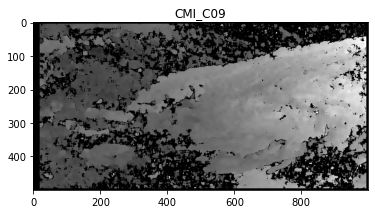

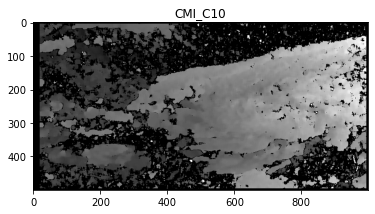

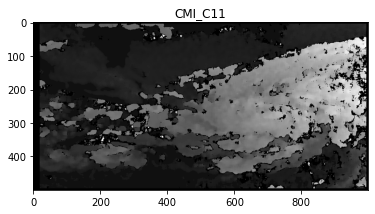

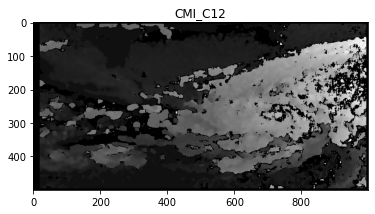

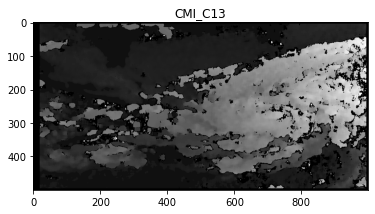

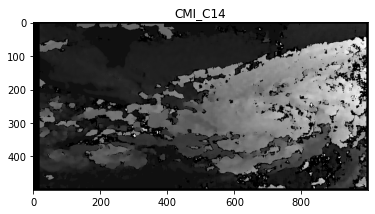

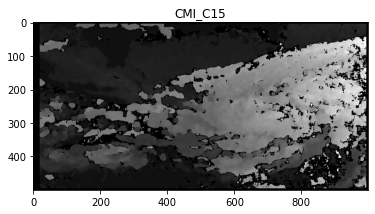

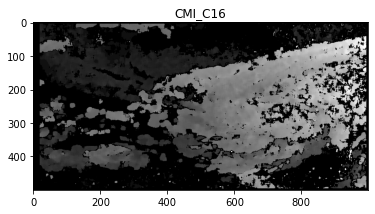

In [149]:
import cv2 as cv
%matplotlib inline
window_size = 3
min_disp = 16
num_disp = 112-min_disp
# stereo = cv.StereoSGBM_create(minDisparity = min_disp,
#     numDisparities = num_disp,
#     blockSize = 16,
#     P1 = 8*3*window_size**2,
#     P2 = 32*3*window_size**2,
#     disp12MaxDiff = 1,
#     uniquenessRatio = 10,
#     speckleWindowSize = 100,
#     speckleRange = 32
# )
stereo = cv.StereoBM_create(numDisparities=16, blockSize=11)
for i in range(1,17):
    disparity = stereo.compute(flow.to_8bit(goes17_remapper(goes17ds['CMI_C%02d'%i].data)), 
                               flow.to_8bit(goes16_remapper(goes16ds['CMI_C%02d'%i].data)))
    plt.figure
    plt.title('CMI_C%02d'%i)
    plt.imshow(disparity,'gray')
    plt.show()

In [150]:
i=13
disparity = stereo.compute(flow.to_8bit(goes17_remapper(goes17ds['CMI_C%02d'%i].data)), 
                               flow.to_8bit(goes16_remapper(goes16ds['CMI_C%02d'%i].data)))

In [155]:
disparity = np.nanmean([stereo.compute(flow.to_8bit(goes17_remapper(goes17ds['CMI_C%02d'%i].data)), 
                                       flow.to_8bit(goes16_remapper(goes16ds['CMI_C%02d'%i].data)))
                        for i in [1,2,3,7,12,13]], 0)

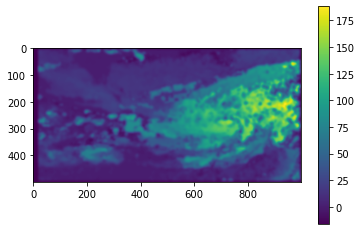

In [158]:
%matplotlib inline
plt.figure()
plt.imshow(ndi.gaussian_filter(disparity,4))
plt.colorbar()

(-16.0, 1000.0)

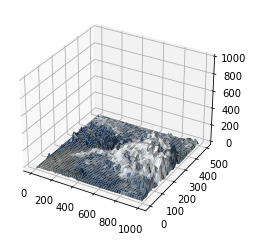

In [159]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(*np.meshgrid(np.arange(1000), np.arange(500)), ndi.gaussian_filter(disparity,4), facecolors=goes16_remapper(abi.get_abi_rgb(goes16ds)), linewidth=0)
ax.set_zlim([-16,1000])


<IPython.core.display.Javascript object>


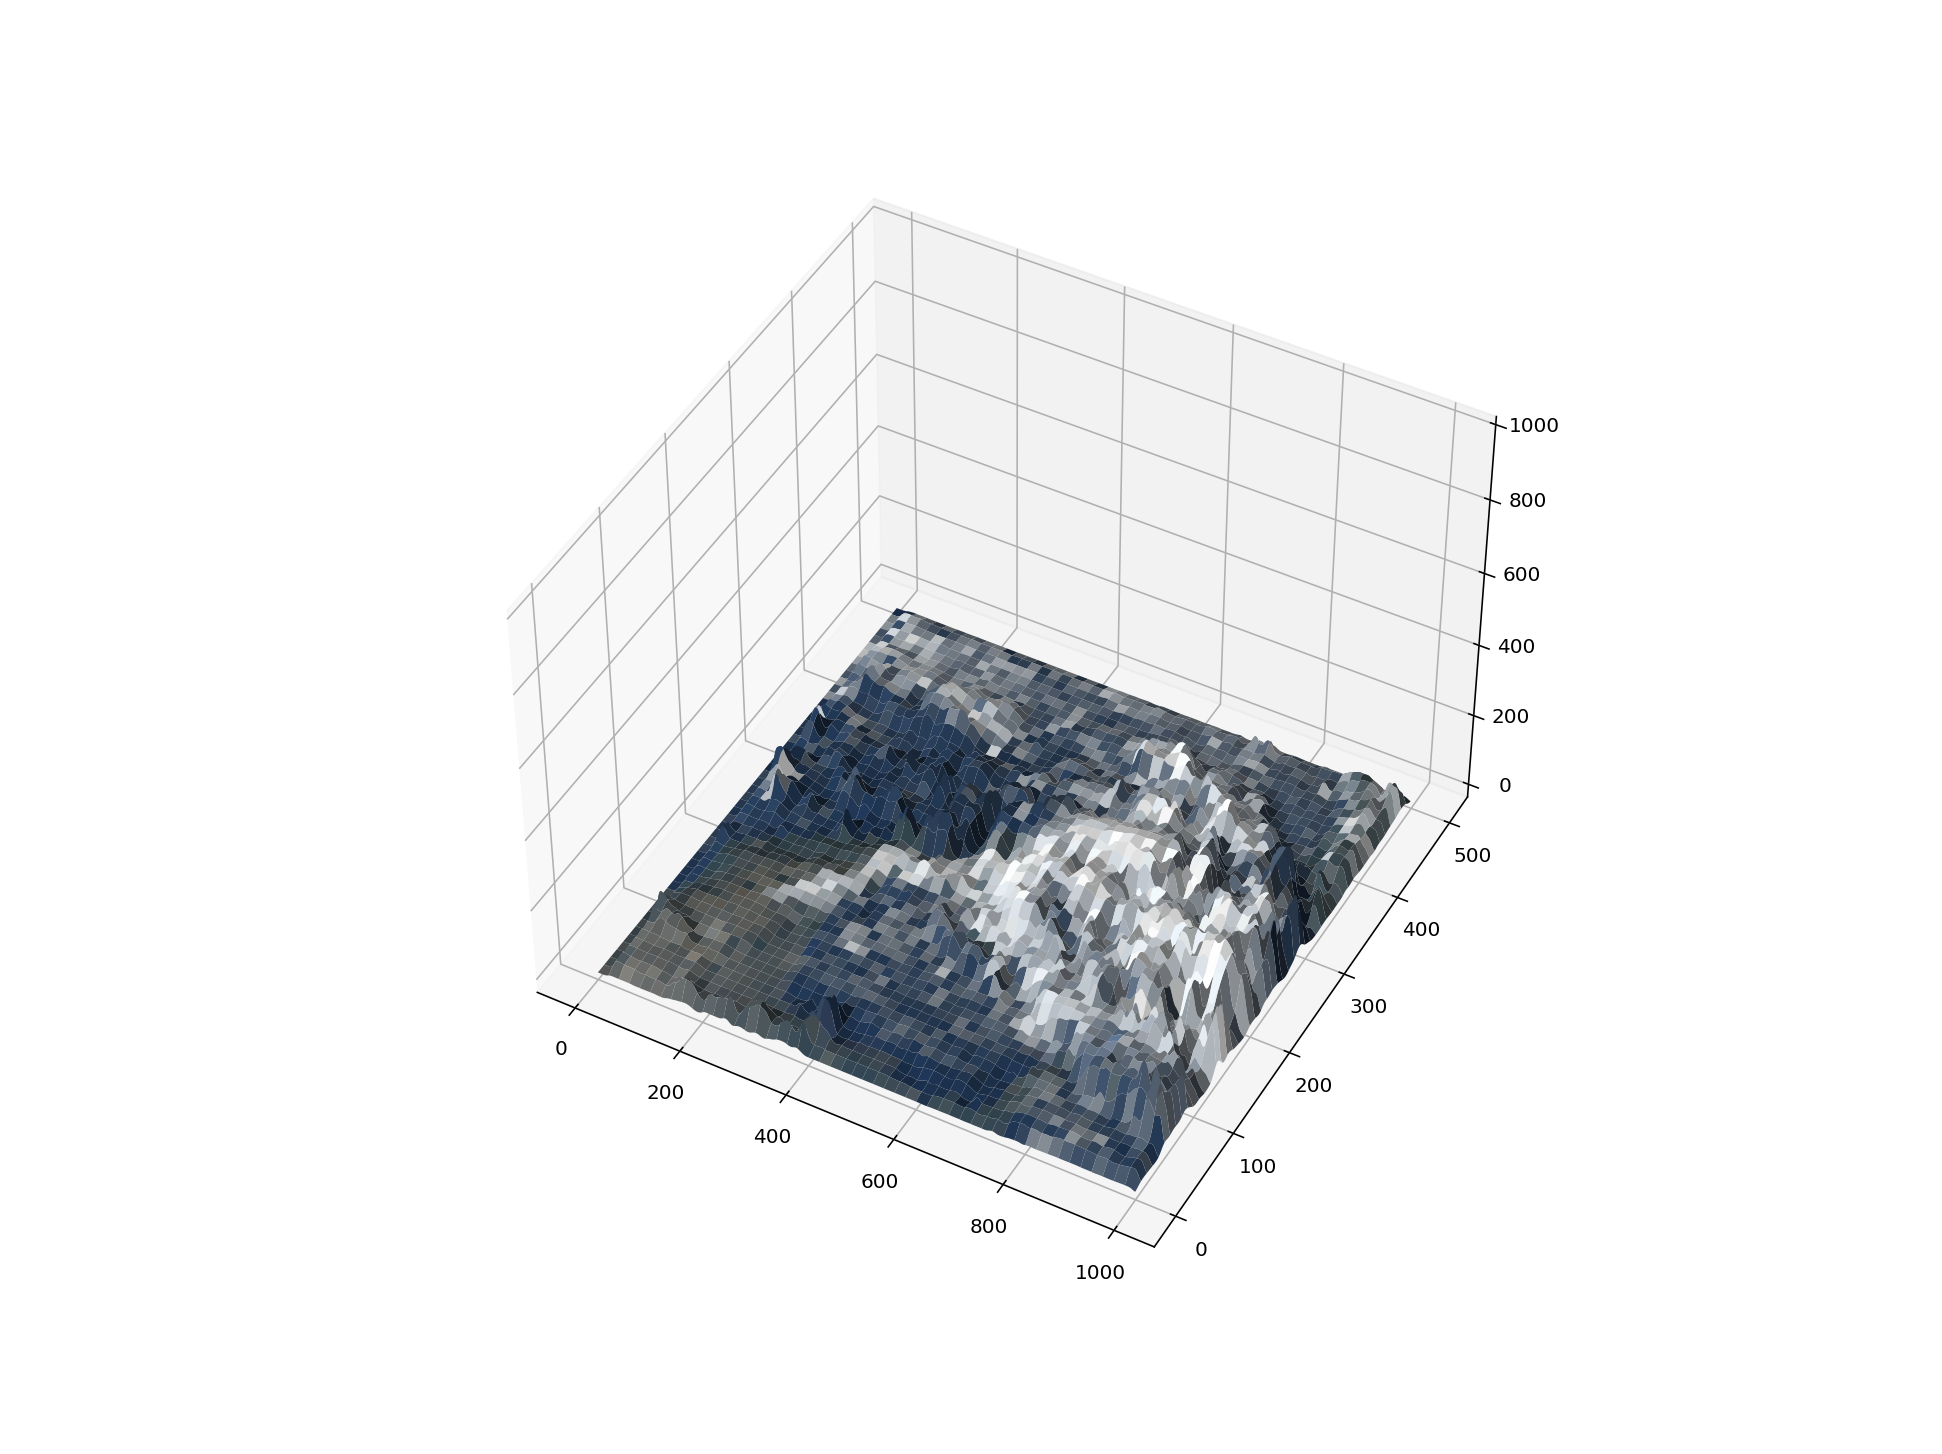

In [161]:
%matplotlib nbagg
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(*np.meshgrid(np.arange(1000), np.arange(500)), ndi.gaussian_filter(disparity,4), facecolors=goes16_remapper(abi.get_abi_rgb(goes16ds)), linewidth=0)
ax.set_zlim([-16,1000])
plt.show()